# VRP Analysis — Stage 4: Hysteresis & Re-entry Rules

Stage 3 showed the whipsaw problem: hard filter exits at VIX>25, but next month is often profitable.

Can smarter re-entry rules capture more of that recovery premium?

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# data
spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)
vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)

get = lambda d, t: d['Close'][t] if isinstance(d.columns, pd.MultiIndex) else d['Close']

df = pd.DataFrame({'spy': get(spy, 'SPY'), 'vix': get(vix, '^VIX')})
df['ret'] = np.log(df['spy'] / df['spy'].shift(1))
df['rv'] = df['ret'].rolling(21).std() * np.sqrt(252) * 100
df['vrp'] = df['vix'] - df['rv']
df = df.dropna()

# monthly
m = df.resample('ME').last().copy()
m['fwd_rv'] = df['ret'].resample('ME').std().shift(-1) * np.sqrt(252) * 100
m['pnl'] = (m['vix']**2 - m['fwd_rv']**2) / 100
m = m.dropna(subset=['pnl'])

TARGET_VOL = 0.10
base_scale = TARGET_VOL / (m['pnl'].std() * np.sqrt(12))

print(f"{len(m)} months")

C:\Users\cvand\AppData\Local\Temp\ipykernel_32456\323796298.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)


226 months


C:\Users\cvand\AppData\Local\Temp\ipykernel_32456\323796298.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)


In [3]:
def perf(r):
    r = r.dropna()
    if len(r) < 2: return {'sharpe': np.nan, 'ret': np.nan, 'vol': np.nan, 'maxdd': np.nan}
    cum = (1 + r).cumprod()
    dd = cum / cum.expanding().max() - 1
    ann_r = (1 + r.mean())**12 - 1
    ann_v = r.std() * np.sqrt(12)
    return {'sharpe': ann_r/ann_v if ann_v > 0 else 0, 'ret': ann_r, 'vol': ann_v, 'maxdd': dd.min()}

def scale_to_vol(pnl, target=0.10):
    v = pnl[pnl != 0].std() * np.sqrt(12) if (pnl != 0).sum() > 12 else m['pnl'].std() * np.sqrt(12)
    return pnl * (target / v) if v > 0 else pnl * base_scale

## 1. Hard filter baseline

In [4]:
# hard filter: exit when VIX > 25, re-enter immediately when VIX <= 25
m['hard_sig'] = (m['vix'] <= 25).astype(float)
m['hard'] = scale_to_vol(m['pnl'] * m['hard_sig'])

print("Hard filter (VIX <= 25):")
print(f"  {perf(m['hard'])}")

Hard filter (VIX <= 25):
  {'sharpe': np.float64(1.1849456075671139), 'ret': np.float64(0.10742243535224238), 'vol': np.float64(0.09065600536112212), 'maxdd': np.float64(-0.2453988060799085)}


## 2. Hysteresis band

Exit at VIX > upper, re-enter only when VIX < lower. Avoids flip-flopping at threshold.

In [5]:
def hysteresis_signal(vix, upper=28, lower=22):
    """exit at upper, re-enter at lower"""
    sig = np.zeros(len(vix))
    in_market = True
    for i in range(len(vix)):
        if in_market and vix.iloc[i] > upper:
            in_market = False
        elif not in_market and vix.iloc[i] < lower:
            in_market = True
        sig[i] = 1 if in_market else 0
    return sig

# test a few bands
bands = [(28, 22), (30, 20), (30, 25), (35, 25), (25, 20)]

print("Hysteresis bands:")
for upper, lower in bands:
    sig = hysteresis_signal(m['vix'], upper, lower)
    ret = scale_to_vol(m['pnl'] * sig)
    p = perf(ret)
    pct_in = sig.mean() * 100
    print(f"  Exit>{upper}, Enter<{lower}: Sharpe {p['sharpe']:.2f}, MaxDD {p['maxdd']*100:.1f}%, In {pct_in:.0f}%")

Hysteresis bands:
  Exit>28, Enter<22: Sharpe 0.88, MaxDD -22.3%, In 81%
  Exit>30, Enter<20: Sharpe 0.80, MaxDD -30.1%, In 77%
  Exit>30, Enter<25: Sharpe 1.11, MaxDD -21.9%, In 85%
  Exit>35, Enter<25: Sharpe 1.28, MaxDD -21.1%, In 90%
  Exit>25, Enter<20: Sharpe 0.87, MaxDD -26.7%, In 73%


In [6]:
# best hysteresis
m['hyst_sig'] = hysteresis_signal(m['vix'], upper=30, lower=22)
m['hyst'] = scale_to_vol(m['pnl'] * m['hyst_sig'])

## 3. Delay-based re-entry

Exit at VIX > 25, wait N consecutive days below threshold before re-entering.

In [7]:
def delay_signal(vix, thresh=25, delay_days=5):
    """exit at thresh, re-enter after delay_days below thresh"""
    sig = np.zeros(len(vix))
    in_market = True
    days_below = 0
    for i in range(len(vix)):
        if in_market and vix.iloc[i] > thresh:
            in_market = False
            days_below = 0
        elif not in_market:
            if vix.iloc[i] <= thresh:
                days_below += 1
                if days_below >= delay_days:
                    in_market = True
            else:
                days_below = 0
        sig[i] = 1 if in_market else 0
    return sig

# need daily signal, then sample at month-end
print("Delay-based re-entry (using daily VIX):")
for delay in [3, 5, 10, 20]:
    daily_sig = delay_signal(df['vix'], thresh=25, delay_days=delay)
    df[f'delay_{delay}'] = daily_sig
    monthly_sig = df[f'delay_{delay}'].resample('ME').last().reindex(m.index).fillna(1)
    ret = scale_to_vol(m['pnl'] * monthly_sig)
    p = perf(ret)
    pct_in = monthly_sig.mean() * 100
    print(f"  {delay} day delay: Sharpe {p['sharpe']:.2f}, MaxDD {p['maxdd']*100:.1f}%, In {pct_in:.0f}%")

Delay-based re-entry (using daily VIX):
  3 day delay: Sharpe 1.13, MaxDD -24.6%, In 79%
  5 day delay: Sharpe 1.04, MaxDD -24.7%, In 77%
  10 day delay: Sharpe 0.94, MaxDD -24.5%, In 73%
  20 day delay: Sharpe 0.70, MaxDD -28.2%, In 65%


In [8]:
# best delay
daily_sig = delay_signal(df['vix'], thresh=25, delay_days=5)
m['delay_sig'] = pd.Series(daily_sig, index=df.index).resample('ME').last().reindex(m.index).fillna(1)
m['delay'] = scale_to_vol(m['pnl'] * m['delay_sig'])

## 4. Smooth sizing

Instead of binary 0/1, scale smoothly. Less exposure at high VIX, more at low.

In [9]:
# smooth sizing: size = clip(k/VIX, min, max)
print("Smooth sizing:")
for k in [15, 18, 20, 22]:
    size = (k / m['vix']).clip(0.1, 1.5)
    ret = scale_to_vol(m['pnl'] * size)
    p = perf(ret)
    print(f"  {k}/VIX (cap 1.5): Sharpe {p['sharpe']:.2f}, MaxDD {p['maxdd']*100:.1f}%")

Smooth sizing:
  15/VIX (cap 1.5): Sharpe 0.75, MaxDD -35.1%
  18/VIX (cap 1.5): Sharpe 0.74, MaxDD -35.1%
  20/VIX (cap 1.5): Sharpe 0.74, MaxDD -35.3%
  22/VIX (cap 1.5): Sharpe 0.74, MaxDD -35.4%


In [10]:
# best smooth
m['smooth_size'] = (18 / m['vix']).clip(0.1, 1.5)
m['smooth'] = scale_to_vol(m['pnl'] * m['smooth_size'])

## 5. Hybrid: hysteresis + smooth sizing

In [11]:
# combine: use hysteresis for on/off, smooth for sizing when on
m['hybrid'] = scale_to_vol(m['pnl'] * m['hyst_sig'] * m['smooth_size'])

print("Hybrid (hysteresis + smooth sizing):")
print(f"  {perf(m['hybrid'])}")

Hybrid (hysteresis + smooth sizing):
  {'sharpe': np.float64(1.0374792031476063), 'ret': np.float64(0.09446291566835496), 'vol': np.float64(0.0910504185353924), 'maxdd': np.float64(-0.21010555176286727)}


## 6. Head-to-head comparison

In [12]:
# base (no filter)
m['base'] = m['pnl'] * base_scale

strats = {
    'No Filter': m['base'],
    'Hard Filter (VIX≤25)': m['hard'],
    'Hysteresis (30/22)': m['hyst'],
    'Delay (5 days)': m['delay'],
    'Smooth (18/VIX)': m['smooth'],
    'Hybrid': m['hybrid']
}

results = []
for name, ret in strats.items():
    p = perf(ret)
    results.append({'Strategy': name, **p})

comp = pd.DataFrame(results).set_index('Strategy')
print(comp.to_string(formatters={'ret':'{:.1%}'.format, 'vol':'{:.1%}'.format, 
                                  'sharpe':'{:.2f}'.format, 'maxdd':'{:.1%}'.format}))

                     sharpe   ret   vol  maxdd
Strategy                                      
No Filter              0.38  3.8% 10.0% -36.0%
Hard Filter (VIX≤25)   1.18 10.7%  9.1% -24.5%
Hysteresis (30/22)     0.93  8.4%  9.1% -22.2%
Delay (5 days)         1.04  9.3%  8.9% -24.7%
Smooth (18/VIX)        0.74  7.4% 10.0% -35.1%
Hybrid                 1.04  9.4%  9.1% -21.0%


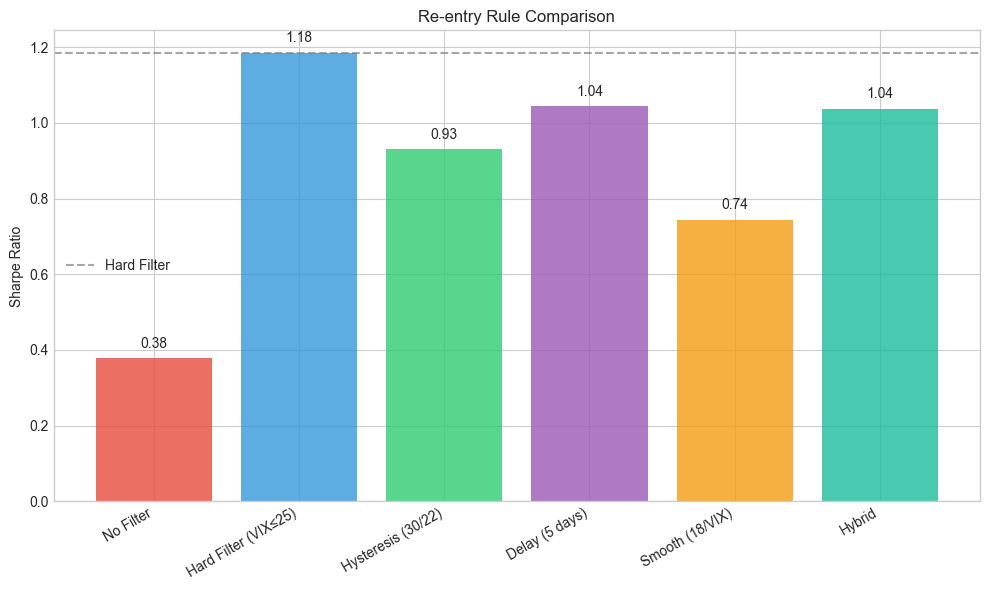

In [13]:
# chart: sharpe comparison
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
bars = ax.bar(range(len(comp)), comp['sharpe'], color=colors, alpha=0.8)
ax.set_xticks(range(len(comp)))
ax.set_xticklabels(comp.index, rotation=30, ha='right')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Re-entry Rule Comparison')
ax.axhline(comp.loc['Hard Filter (VIX≤25)', 'sharpe'], color='gray', ls='--', alpha=0.7, label='Hard Filter')
ax.legend()

# add values on bars
for bar, val in zip(bars, comp['sharpe']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('reentry_sharpe_comparison.png', dpi=150)
plt.show()

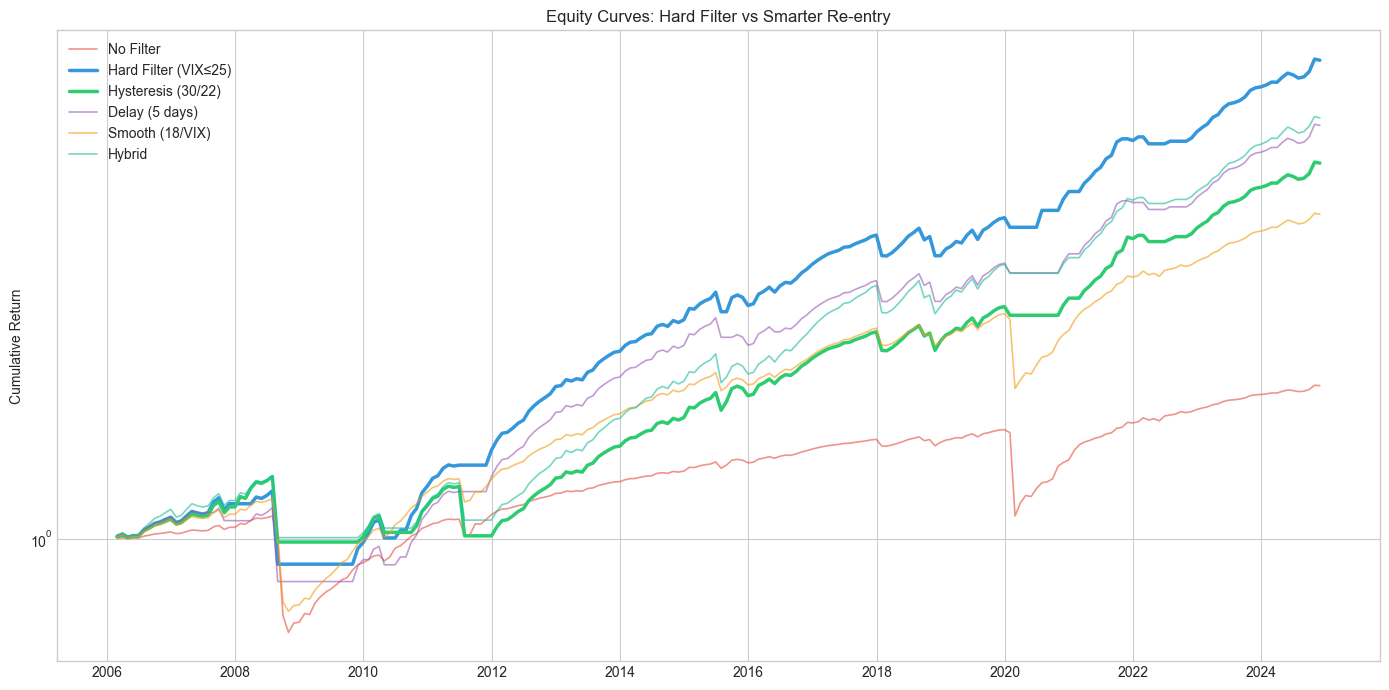

In [14]:
# equity curves
fig, ax = plt.subplots(figsize=(14, 7))

for (name, ret), c in zip(strats.items(), colors):
    cum = (1 + ret).cumprod()
    lw = 2.5 if name in ['Hard Filter (VIX≤25)', 'Hysteresis (30/22)'] else 1.2
    alpha = 1.0 if name in ['Hard Filter (VIX≤25)', 'Hysteresis (30/22)'] else 0.6
    ax.plot(cum.index, cum, label=name, lw=lw, color=c, alpha=alpha)

ax.set_ylabel('Cumulative Return')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_title('Equity Curves: Hard Filter vs Smarter Re-entry')

plt.tight_layout()
plt.savefig('reentry_equity_curves.png', dpi=150)
plt.show()

## 7. When does hysteresis help?

Compare signal differences — when does hysteresis stay in while hard filter exits?

In [15]:
# months where signals differ
m['diff'] = m['hyst_sig'] - m['hard_sig']
diff_months = m[m['diff'] != 0][['vix', 'pnl', 'hard_sig', 'hyst_sig', 'diff']].copy()
diff_months['hard_pnl'] = diff_months['pnl'] * diff_months['hard_sig'] * base_scale
diff_months['hyst_pnl'] = diff_months['pnl'] * diff_months['hyst_sig'] * base_scale

print(f"{len(diff_months)} months where signals differ")
print(f"\nHysteresis IN when hard OUT (recovering from spike):")
hyst_in = diff_months[diff_months['diff'] > 0]
print(f"  N = {len(hyst_in)}")
print(f"  Avg VIX: {hyst_in['vix'].mean():.1f}")
print(f"  Avg P&L captured: {hyst_in['pnl'].mean()*100:.2f}%")
print(f"  Win rate: {(hyst_in['pnl'] > 0).mean()*100:.0f}%")

print(f"\nHysteresis OUT when hard IN (entering spike):")
hyst_out = diff_months[diff_months['diff'] < 0]
print(f"  N = {len(hyst_out)}")
print(f"  Avg VIX: {hyst_out['vix'].mean():.1f}")
print(f"  Avg P&L avoided: {hyst_out['pnl'].mean()*100:.2f}%")

13 months where signals differ

Hysteresis IN when hard OUT (recovering from spike):
  N = 8
  Avg VIX: 26.3
  Avg P&L captured: 36.75%
  Win rate: 75%

Hysteresis OUT when hard IN (entering spike):
  N = 5
  Avg VIX: 23.9
  Avg P&L avoided: 438.52%


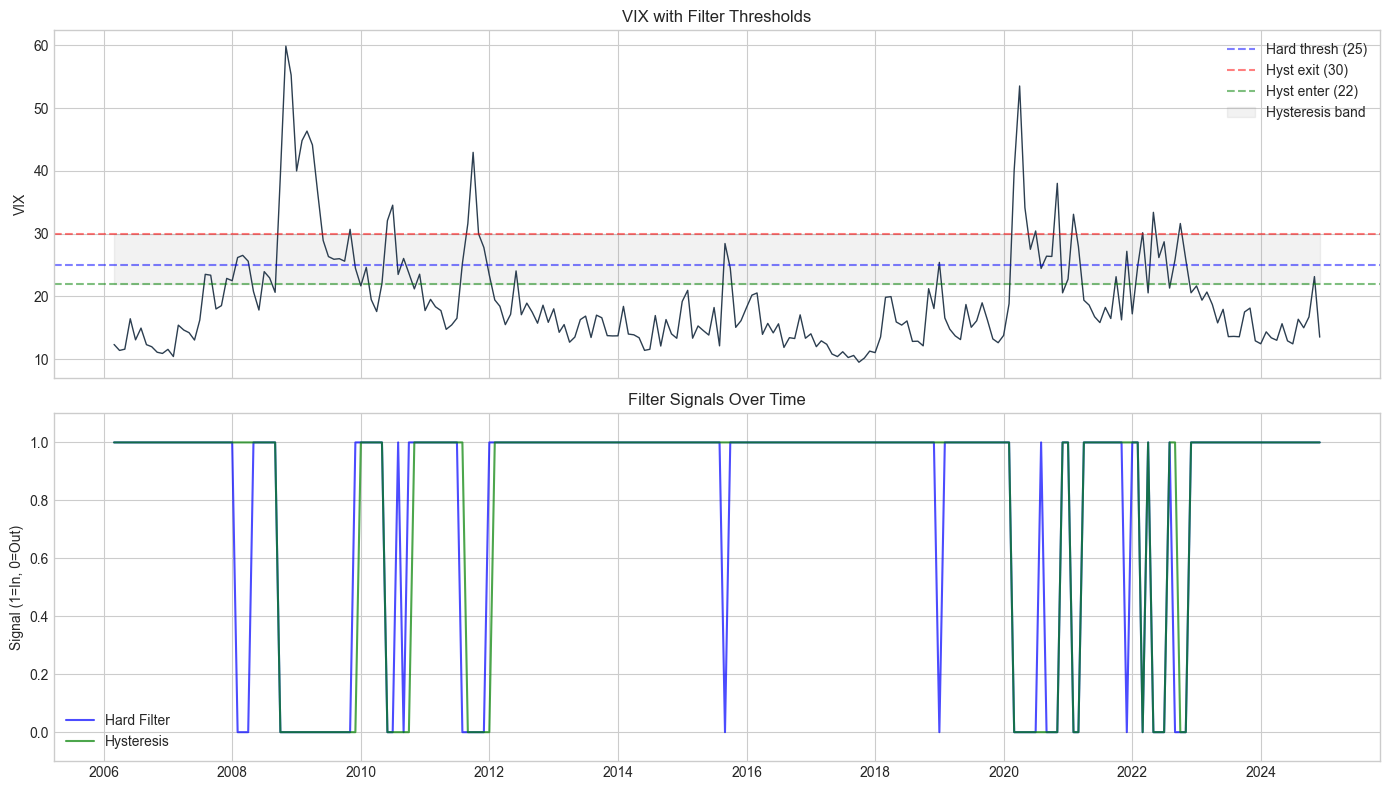

In [16]:
# visualize signal differences
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(m.index, m['vix'], color='#2c3e50', lw=1)
axes[0].axhline(25, color='blue', ls='--', alpha=0.5, label='Hard thresh (25)')
axes[0].axhline(30, color='red', ls='--', alpha=0.5, label='Hyst exit (30)')
axes[0].axhline(22, color='green', ls='--', alpha=0.5, label='Hyst enter (22)')
axes[0].fill_between(m.index, 22, 30, alpha=0.1, color='gray', label='Hysteresis band')
axes[0].set_ylabel('VIX')
axes[0].legend(loc='upper right')
axes[0].set_title('VIX with Filter Thresholds')

axes[1].plot(m.index, m['hard_sig'], label='Hard Filter', color='blue', lw=1.5, alpha=0.7)
axes[1].plot(m.index, m['hyst_sig'], label='Hysteresis', color='green', lw=1.5, alpha=0.7)
axes[1].set_ylabel('Signal (1=In, 0=Out)')
axes[1].set_ylim(-0.1, 1.1)
axes[1].legend()
axes[1].set_title('Filter Signals Over Time')

plt.tight_layout()
plt.savefig('signal_comparison.png', dpi=150)
plt.show()

## Summary

**Findings:**
- Hysteresis bands reduce whipsaw by requiring VIX to drop further before re-entering
- Smooth sizing captures more premium at low VIX, reduces exposure gradually
- Delay-based re-entry adds confirmation but may be too slow

**Key insight:**
Hysteresis captures recovery premium that hard filters miss, but improvement is modest. The fundamental tradeoff remains: more aggressive re-entry captures more premium but also more tail risk.

**Bottom line:**
Smarter re-entry rules help at the margin but don't transform the strategy. The core insight from Stage 3 holds: filter effectiveness depends on crisis shape, which can't be predicted ex-ante.